In [11]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [234]:
# A simple version of Attention
from tensorflow import keras
from tensorflow.keras import layers


class Attention(keras.Model):
    """
    Usage:
        model = keras.models.Sequential()
        model.add(LSTM(n_units, return_sequence=True))  # Set return_sequence to True
        model.add(Attention())
        model.add(Dense(n_class, activation='softmax'))
    """
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        time_step = input_shape[1]
        self.dense_1 = layers.Dense(time_step, activation='softmax')
        super().build(tf.TensorShape(input_shape))
        
    def call(self, x):
        # a workaround for having batch_size equals to None, during the building phase
        input_shape = tf.TensorShape(x.shape)
        batch_size, flatten_feature_dim = input_shape[0], input_shape[1:].num_elements()
        alpha = self.dense_1(tf.reshape(x, (batch_size or -1, flatten_feature_dim)))  # [batch_size, time_step]
        alpha = tf.expand_dims(alpha, -1)
        
        context_vector = tf.reduce_sum(tf.multiply(alpha, x), axis=1) 
        
        # concatenate the context vector with the last output from previous layer
        output_vector = layers.Concatenate()([context_vector, x[:, -1, :]])
        return output_vector
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [235]:
# build two LSTM, one w/ and one w/o attention
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

plain_lstm = Sequential([
    Embedding(5000, 20, input_length=100),  # 5000 is the vocab_size
    LSTM(10),
    Dense(2, activation='softmax')
])

attn_lstm = Sequential([
    Embedding(5000, 20, input_length=100),
    LSTM(10, return_sequences=True),
    Attention(),
    Dense(2, activation='softmax')
])

plain_lstm.compile(optimizer=Adam(), 
                   loss=CategoricalCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

attn_lstm.compile(optimizer=Adam(), 
                   loss=CategoricalCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

### Test on the IMDB dataset

In [135]:
import sys
sys.path.append('../')

from utils.datasets import create_imdb_dataset
from utils.plotting import *

In [ ]:
plain_history = plain_lstm.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
667/782 [========================>.....] - ETA: 5s - loss: 0.5459 - accuracy: 0.7606

In [ ]:
plot_training_history(plain_history, keyword='accuracy')

In [236]:
attn_history = attn_lstm.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
782/782 [==============================] - 49s 63ms/step - loss: 0.5160 - accuracy: 0.7887 - val_loss: 0.4639 - val_accuracy: 0.8443
Epoch 2/10
782/782 [==============================] - 47s 60ms/step - loss: 0.4374 - accuracy: 0.8716 - val_loss: 0.4662 - val_accuracy: 0.8394
Epoch 3/10
782/782 [==============================] - 39s 50ms/step - loss: 0.4203 - accuracy: 0.8907 - val_loss: 0.4660 - val_accuracy: 0.8398
Epoch 4/10
782/782 [==============================] - 43s 55ms/step - loss: 0.4112 - accuracy: 0.9001 - val_loss: 0.4653 - val_accuracy: 0.8418
Epoch 5/10
782/782 [==============================] - 40s 51ms/step - loss: 0.4047 - accuracy: 0.9069 - val_loss: 0.4663 - val_accuracy: 0.8412
Epoch 6/10
782/782 [==============================] - 40s 51ms/step - loss: 0.3955 - accuracy: 0.9171 - val_loss: 0.4682 - val_accuracy: 0.8381
Epoch 7/10
782/782 [==============================] - 39s 50ms/step - loss: 0.3911 - accuracy: 0.9212 - val_loss: 0.4661 - val_accuracy:

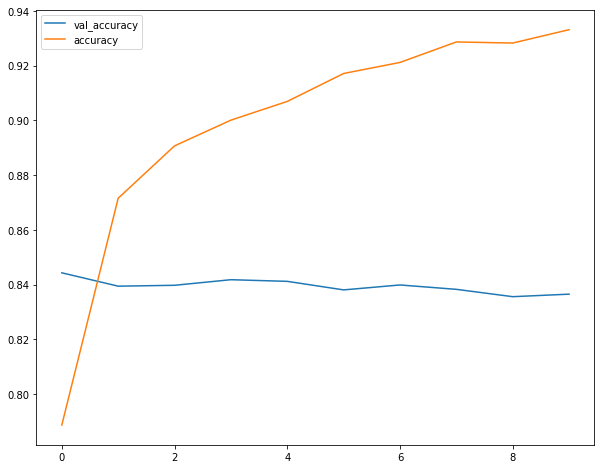

In [239]:
plot_training_history(attn_history, keyword='accuracy')

In [119]:
from tensorflow import keras
from tensorflow.keras.layers import LSTM

import numpy as np

sample = np.random.random((32, 50, 10)).astype('float32')
output = layers.Bidirectional(LSTM(units=20, return_sequences=True, return_state=False))(sample)

# for idx, o in enumerate(output):
#     print(idx, o.shape)
output.shape

TensorShape([32, 50, 40])